In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score,make_scorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import cross_val_score
import eli5
import ast
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

# RFE feature selection

In [2]:
tissue_rf=pd.read_csv("/home/zgao/R/GEO_count/pan_train.csv")

In [3]:
tissue_rf.iloc[:,0]
tissue_rf = tissue_rf.drop(columns=['Unnamed: 0'])
tissue_rf.shape

(812, 15)

In [4]:
X = tissue_rf.drop(columns=['group'])
y = tissue_rf['group']

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
feature_names = X.columns.tolist()
print(feature_names)

['piR-hsa-100956', 'piR-hsa-1288731', 'piR-hsa-131631', 'piR-hsa-138412', 'piR-hsa-141155', 'piR-hsa-148273', 'piR-hsa-2499988', 'piR-hsa-2826866', 'piR-hsa-2826956', 'piR-hsa-2831324', 'piR-hsa-2833690', 'piR-hsa-2838249', 'piR-hsa-2851625', 'piR-hsa-2851799']


In [6]:
selector = RFE(estimator=rf_classifier)
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [None, 10, 20],
    'n_features_to_select': [i for i in range(10,30,1)]
}

In [7]:
grid_search = GridSearchCV(selector, param_grid, cv=5,n_jobs=50)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=RFE(estimator=RandomForestClassifier(random_state=42)),
             n_jobs=50,
             param_grid={'estimator__max_depth': [None, 10, 20],
                         'estimator__n_estimators': [50, 100, 200],
                         'n_features_to_select': [10, 11, 12, 13, 14, 15, 16,
                                                  17, 18, 19, 20, 21, 22, 23,
                                                  24, 25, 26, 27, 28, 29]})

In [8]:
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'estimator__max_depth': None, 'estimator__n_estimators': 100, 'n_features_to_select': 13}


In [9]:
best_estimator = grid_search.best_estimator_

In [10]:
scores = cross_val_score(best_estimator, X, y, cv=5)
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

# Print the average accuracy
print(f"Average CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Fold 1: 0.8528
Fold 2: 0.8466
Fold 3: 0.7901
Fold 4: 0.7407
Fold 5: 0.7407
Average CV Accuracy: 0.7942 ± 0.0488


In [11]:
selected_features_mask = best_estimator.support_
feature_names = X.columns
selected_feature_names = feature_names[selected_features_mask]

In [12]:
feature_importances = best_estimator.estimator_.feature_importances_

In [13]:
importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': feature_importances
})

In [14]:
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)

            Feature  Importance
0    piR-hsa-100956    0.121713
12  piR-hsa-2851799    0.097606
2    piR-hsa-131631    0.082284
5   piR-hsa-2499988    0.077210
10  piR-hsa-2838249    0.074041
1   piR-hsa-1288731    0.073504
3    piR-hsa-138412    0.071882
8   piR-hsa-2831324    0.070847
9   piR-hsa-2833690    0.069865
4    piR-hsa-141155    0.068907
6   piR-hsa-2826866    0.067721
7   piR-hsa-2826956    0.062570
11  piR-hsa-2851625    0.061850


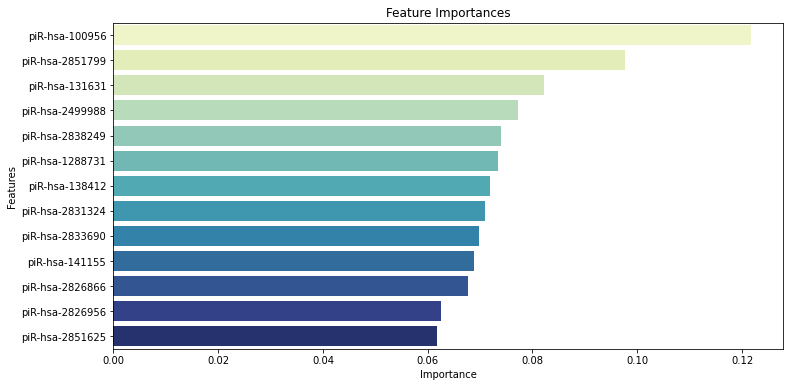

In [17]:
# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=sorted_importance_df,palette='YlGnBu')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
#plt.savefig("/home/zgao/R/GEO_count/plot_new/TCGA_match_feature_importance.pdf", format='pdf')
plt.show()

# 13 piRNA training in random forest(e.g. GSE62182)

In [18]:
piRNA_rf=pd.read_csv("/home/zgao/R/GEO_count/pan_train2.csv")

In [19]:
piRNA_rf=piRNA_rf.drop(columns=['Unnamed: 0'])

In [20]:
X_train = piRNA_rf.drop(columns=['group'])
y_train = piRNA_rf['group']

In [21]:
test=pd.read_csv("/home/zgao/R/GEO_count/pan_test2.csv")
test=pd.read_csv("/home/zgao/R/GEO_count/tissue_test2.csv")
test=pd.read_csv("/home/zgao/R/GEO_count/plasma_test2.csv")
test=pd.read_csv("/home/zgao/R/GEO_count/exosome_test2.csv")
test=pd.read_csv("/home/zgao/R/GEO_count/exosome_test2_CH.csv")
test=pd.read_csv("/home/zgao/R/GEO_count/exosome_test2_BC.csv")
#independent cohort
test=pd.read_csv("/home/zgao/R/GEO_count/GSE62182_rf.csv")
#test=pd.read_csv("/home/zgao/R/GEO_count/GSE83527_rf.csv")

In [22]:
test=test.drop(columns=['Unnamed: 0'])
X_test=test.drop(columns=['group'])
y_test=test['group']

In [23]:
rf_classifier_13 = RandomForestClassifier(random_state=42)
rf_classifier_13.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200,300],
    'max_features': ['sqrt', 2, 3, 4, 5],
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_split': [2, 3, 4],
   'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True, False]
}

In [25]:
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                           cv=5, n_jobs=50, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=50,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [2, 3, 4, 5, None],
                         'max_features': ['sqrt', 2, 3, 4, 5],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [27]:
best_params = grid_search.best_params_
best_params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
print("Best parameters found: ", best_params)

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}


In [28]:
best_rf_classifier = RandomForestClassifier(**best_params,random_state=42)
best_rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_features='sqrt', min_samples_leaf=3, n_estimators=50,
                       random_state=42)

In [29]:
accuracy_train = best_rf_classifier.score(X_train, y_train)
print("train set accuracy: ", accuracy_train)

average_cv_accuracy = grid_search.best_score_
print("Average CV accuracy: ", average_cv_accuracy)

accuracy_test = best_rf_classifier.score(X_test, y_test)
print("Test set accuracy: ", accuracy_test)

train set accuracy:  0.958128078817734
Average CV accuracy:  0.7929485722941754
Test set accuracy:  0.8928571428571429


In [31]:
def evaluate_performance_youden(y_true, y_proba, pos_label='tumor'):
    # ROC curve
    fpr_youden, tpr_youden, thresholds = roc_curve(y_true, y_proba, pos_label=pos_label)
    auc_value = roc_auc_score(y_true, y_proba)

    print("AUC:", auc_value)

    # Youden's J statistic
    youden_J = tpr_youden - fpr_youden
    optimal_idx_youden = np.argmax(youden_J)
    optimal_threshold_youden = thresholds[optimal_idx_youden]
    best_youden_J = youden_J[optimal_idx_youden]

    print(f"Best Threshold (Youden): {optimal_threshold_youden}")
    print(f"Best Youden's J: {best_youden_J}")

    # Predict based on optimal threshold
    y_pred_labels = np.where(y_proba >= optimal_threshold_youden, pos_label, 'normal')

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels, labels=["normal", pos_label]).ravel()

    # Calculate metrics
    sensitivity_youden = tp / (tp + fn) if (tp + fn) != 0 else 0  # Recall
    specificity_youden = tn / (tn + fp) if (tn + fp) != 0 else 0

    print(f"Sensitivity (Recall): {sensitivity_youden}")
    print(f"Specificity: {specificity_youden}")

    return {
        'auc': auc_value,
        'optimal_threshold': optimal_threshold_youden,
        'best_youden_J': best_youden_J,
        'sensitivity': sensitivity_youden,
        'specificity': specificity_youden,
        'y_pred_labels': y_pred_labels
    }

In [32]:
y_pred_proba_train = best_rf_classifier.predict_proba(X_train)[:, 1]
y_pred_proba_test = best_rf_classifier.predict_proba(X_test)[:, 1]

print(evaluate_performance_youden(y_train, y_pred_proba_train))
print(evaluate_performance_youden(y_test, y_pred_proba_test))

AUC: 0.9956791135298168
Best Threshold (Youden): 0.5624285714285713
Best Youden's J: 0.9399796741304134
Sensitivity (Recall): 0.9806576402321083
Specificity: 0.9593220338983051
{'auc': 0.9956791135298168, 'optimal_threshold': 0.5624285714285713, 'best_youden_J': 0.9399796741304134, 'sensitivity': 0.9806576402321083, 'specificity': 0.9593220338983051, 'y_pred_labels': array(['tumor', 'tumor', 'normal', 'tumor', 'normal', 'tumor', 'tumor',
       'normal', 'tumor', 'normal', 'tumor', 'tumor', 'normal', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'normal', 'tumor',
       'normal', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor',
       'normal', 'tumor', 'tumor', 'tumor', 'normal', 'tumor', 'tumor',
       'tumor', 'tumor', 'normal', 'tumor', 'tumor', 'normal', 'tumor',
       'tumor', 'normal', 'normal', 'normal', 'tumor', 'tumor', 'tumor',
       'normal', 'tumor', 'tumor', 'tumor', 'normal', 'tumor', 'tumor',
       'normal', 'tumor', 'normal', 'normal', 'normal

In [33]:
#threshold at 0.5
y_pred_train=best_rf_classifier.predict(X_train)
f1_train=f1_score(y_train,y_pred_train,pos_label='tumor')
precision_train_score = precision_score(y_train, y_pred_train, pos_label='tumor')
recall_train_score = recall_score(y_train, y_pred_train, pos_label='tumor')
print(f"F1-Score_train: {f1_train}")
print(f"Precision_train: {precision_train_score}")
print(f"Recall_train: {recall_train_score}")

y_pred_test=best_rf_classifier.predict(X_test)
f1_test=f1_score(y_test,y_pred_test,pos_label='tumor')
precision_test_score = precision_score(y_test, y_pred_test, pos_label='tumor')
recall_test_score = recall_score(y_test, y_pred_test, pos_label='tumor')
print(f"F1-Score_test: {f1_test}")
print(f"Precision_test: {precision_test_score}")
print(f"Recall_test: {recall_test_score}")

F1-Score_train: 0.9678030303030303
Precision_train: 0.948051948051948
Recall_train: 0.988394584139265
F1-Score_test: 0.9189189189189189
Precision_test: 0.8717948717948718
Recall_test: 0.9714285714285714


In [34]:
def evaluate_performance(y_true, y_proba, pos_label='tumor'):
    # Compute precision, recall, and optimal thresholds
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba, pos_label=pos_label)
    
    # Calculate F1 scores
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Handle division by zero
    
    # Find optimal threshold
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    best_f1_score = f1_scores[optimal_idx]
    
    # Apply threshold to get predicted labels
    y_pred_labels = np.where(y_proba >= optimal_threshold, pos_label, 'normal')
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels, labels=['normal', pos_label]).ravel()
    
    # Compute metrics
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    auprc = auc(recall, precision)
    
    # Print results
    print("Optimal threshold:", optimal_threshold)
    print("Best F1 score:", best_f1_score)
    print("AUPRC:", auprc)
    print(f"PPV/Precision: {ppv}")
    print(f"NPV: {npv}")
    print(f"Sensitivity/Recall: {sensitivity}")
    print(f"Specificity: {specificity}")
    
    return {
        'optimal_threshold': optimal_threshold,
        'best_f1_score': best_f1_score,
        'auprc': auprc,
        'ppv': ppv,
        'npv': npv,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'y_pred_labels': y_pred_labels
    }


In [35]:
print(evaluate_performance(y_train, y_pred_proba_train))
print(evaluate_performance(y_test, y_pred_proba_test))

Optimal threshold: 0.5624285714285713
Best F1 score: 0.9787644787644788
AUPRC: 0.9976260120765177
PPV/Precision: 0.976878612716763
NPV: 0.9658703071672355
Sensitivity/Recall: 0.9806576402321083
Specificity: 0.9593220338983051
{'optimal_threshold': 0.5624285714285713, 'best_f1_score': 0.9787644787644788, 'auprc': 0.9976260120765177, 'ppv': 0.976878612716763, 'npv': 0.9658703071672355, 'sensitivity': 0.9806576402321083, 'specificity': 0.9593220338983051, 'y_pred_labels': array(['tumor', 'tumor', 'normal', 'tumor', 'normal', 'tumor', 'tumor',
       'normal', 'tumor', 'normal', 'tumor', 'tumor', 'normal', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'tumor', 'normal', 'tumor',
       'normal', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor',
       'normal', 'tumor', 'tumor', 'tumor', 'normal', 'tumor', 'tumor',
       'tumor', 'tumor', 'normal', 'tumor', 'tumor', 'normal', 'tumor',
       'tumor', 'normal', 'normal', 'normal', 'tumor', 'tumor', 'tumor',
       'normal', 'tum

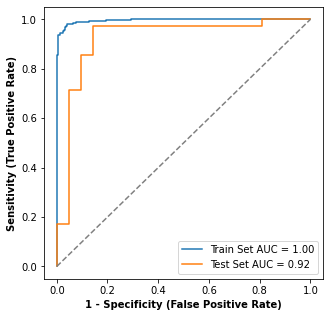

In [36]:
#AUC curve
# Assuming fpr_val, tpr_val, and auc_val contain the FPR, TPR, and AUC for the validation set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train, pos_label='tumor')
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test, pos_label='tumor')
auc_value_train = roc_auc_score(y_train, y_pred_proba_train)
auc_value_test = roc_auc_score(y_test, y_pred_proba_test)

plt.figure(figsize=(5, 5))

# plot ROC curve for the train set
plt.plot(fpr_train, tpr_train, label=f'Train Set AUC = {auc_value_train:.2f}')

# Plot ROC curve for the test set
plt.plot(fpr_test, tpr_test, label=f'Test Set AUC = {auc_value_test:.2f}')

# Plot ROC curve for the validation set
# plt.plot(fpr_val, tpr_val, label=f'Validation Set AUC = {auc_value_val:.2f}', linestyle='-.')  # You can change the linestyle as you like

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labels, title, and other settings
plt.xlabel('1 - Specificity (False Positive Rate)', fontweight='bold')
plt.ylabel('Sensitivity (True Positive Rate)', fontweight='bold')
legend = plt.legend(loc='lower right')
plt.grid(False)
plt.show()

auprc_train: 0.9976260120765177
auprc_test: 0.933513414249995


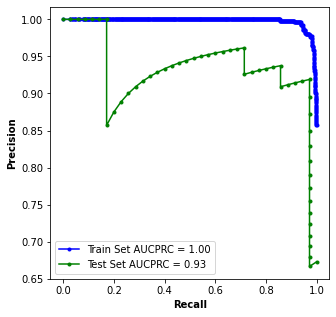

In [37]:
#precision-recall
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train,pos_label='tumor')
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test,pos_label='tumor')
auprc_train = auc(recall_train, precision_train)
print("auprc_train:", auprc_train)
auprc_test = auc(recall_test, precision_test)
print("auprc_test:", auprc_test)

# precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba_val,pos_label='tumor')


plt.figure(figsize=(5, 5))
plt.plot(recall_train, precision_train, marker='.', label=f'Train Set AUCPRC = {auprc_train:.2f}', color='blue')

# Plot for test set
plt.plot(recall_test, precision_test, marker='.', label=f'Test Set AUCPRC = {auprc_test:.2f}', color='green')

# Plot for validation set
# plt.plot(recall_val, precision_val, marker='.', label='Validation', color='red')

# Labeling the axes and setting the title
plt.xlabel('Recall',fontweight='bold')
plt.ylabel('Precision',fontweight='bold')
#plt.title('Exosome Cohort benign vs cancer',fontweight='bold')

# Display the legend
plt.legend()
# Show the plot
plt.show()

In [38]:
def compute_metrics_from_cm(cm):
    # Extracting values from the confusion matrix
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculating Sensitivity and Specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    

    return sensitivity, specificity

In [39]:
#p is the optimal value
y_pred_train_labels = ["tumor" if p >= 0.56 else "normal" for p in y_pred_proba_train]
y_pred_test_labels = ["tumor" if p >= 0.5276904761904763  else "normal" for p in y_pred_proba_test]

In [40]:
cm_test = confusion_matrix(y_test, y_pred_test_labels)
print("Confusion Matrix:")
print(cm_test)
sensitivity_test, specificity_test = compute_metrics_from_cm(cm_test)
print("sensitivity_test, specificity_test:")
print(sensitivity_test, specificity_test)

cm_train = confusion_matrix(y_train, y_pred_train_labels)
sensitivity_train, specificity_train = compute_metrics_from_cm(cm_train)
print("sensitivity_train, specificity_train:")
print(sensitivity_train, specificity_train)

Confusion Matrix:
[[18  3]
 [ 1 34]]
sensitivity_test, specificity_test:
0.9714285714285714 0.8571428571428571
sensitivity_train, specificity_train:
0.9806576402321083 0.9491525423728814


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(7, 5), text_size=14):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    if classes is None:
        classes = [str(i) for i in range(n_classes)]
        
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm_norm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set(title='', 
           xlabel='Predicted Label', 
           ylabel='True Label', 
           xticks=np.arange(n_classes), 
           yticks=np.arange(n_classes), 
           xticklabels=classes, 
           yticklabels=classes)
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()

    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size * 1.2)
    
    threshold = (cm_norm.max() + cm_norm.min()) / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)', 
                 horizontalalignment='center', 
                 color='white' if cm_norm[i, j] > threshold else 'black', 
                 size=text_size)
    

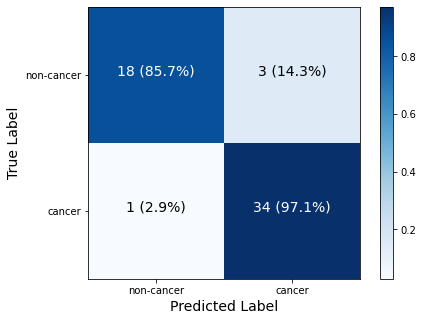

In [42]:
classes = ['non-cancer', 'cancer']
plot_confusion_matrix(y_test, y_pred_test_labels, classes)
plt.show()

# Logistic regression

In [43]:
piRNA_logit=pd.read_csv("/home/zgao/R/GEO_count/pan_train_new.csv")
piRNA_logit=piRNA_logit.set_index('Unnamed: 0')
X_train = piRNA_logit.drop(columns=['group'])
y_train = piRNA_logit['group']

In [44]:
# test_logit=pd.read_csv("R/GEO_count/pan_test_new.csv")
# test_logit=pd.read_csv("R/GEO_count/tissue_test_new.csv")
# test_logit=pd.read_csv("R/GEO_count/plasma_test.csv")
# test_logit=pd.read_csv("R/GEO_count/exosome_test_new.csv")
# test_logit=pd.read_csv("R/GEO_count/pan_test_new_CH.csv")
# test_logit=pd.read_csv("R/GEO_count/exosome_test_new_BC.csv")
# test_logit=pd.read_csv("R/GEO_count/GSE83527_rf2.csv")
test_logit=pd.read_csv("/home/zgao/R/GEO_count/GSE62182_rf2.csv")

In [45]:
test_logit=test_logit.set_index('Unnamed: 0')
X_test=test_logit.drop(columns=['group'])
y_test = test_logit['group']

In [48]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_log = model.predict(X_test)

In [49]:
y_pred_proba_train = y_prob_log = model.predict_proba(X_train)[:, 1]
y_pred_proba_test = y_prob_log = model.predict_proba(X_test)[:, 1]

print(evaluate_performance_youden(y_train, y_pred_proba_train))
print(evaluate_performance_youden(y_test, y_pred_proba_test))

AUC: 0.8122742025374553
Best Threshold (Youden): 0.5598421624836722
Best Youden's J: 0.5217716290200964
Sensitivity (Recall): 0.8471953578336557
Specificity: 0.6745762711864407
{'auc': 0.8122742025374553, 'optimal_threshold': 0.5598421624836722, 'best_youden_J': 0.5217716290200964, 'sensitivity': 0.8471953578336557, 'specificity': 0.6745762711864407, 'y_pred_labels': array(['tumor', 'tumor', 'normal', 'normal', 'tumor', 'tumor', 'tumor',
       'normal', 'tumor', 'tumor', 'tumor', 'normal', 'normal', 'tumor',
       'tumor', 'tumor', 'tumor', 'normal', 'normal', 'normal', 'tumor',
       'normal', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor',
       'normal', 'normal', 'tumor', 'tumor', 'tumor', 'normal', 'tumor',
       'tumor', 'tumor', 'normal', 'normal', 'tumor', 'normal', 'tumor',
       'tumor', 'normal', 'normal', 'tumor', 'tumor', 'tumor', 'normal',
       'normal', 'tumor', 'tumor', 'tumor', 'normal', 'tumor', 'tumor',
       'normal', 'normal', 'normal', 'tumor', 'no

In [50]:
print(evaluate_performance(y_train, y_pred_proba_train))
print(evaluate_performance(y_test, y_pred_proba_test))

Optimal threshold: 0.47432911654214915
Best F1 score: 0.8369565217391305
AUPRC: 0.8607623883166957
PPV/Precision: 0.787052810902896
NPV: 0.7555555555555555
Sensitivity/Recall: 0.8936170212765957
Specificity: 0.576271186440678
{'optimal_threshold': 0.47432911654214915, 'best_f1_score': 0.8369565217391305, 'auprc': 0.8607623883166957, 'ppv': 0.787052810902896, 'npv': 0.7555555555555555, 'sensitivity': 0.8936170212765957, 'specificity': 0.576271186440678, 'y_pred_labels': array(['tumor', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'tumor', 'normal', 'normal', 'tumor',
       'tumor', 'tumor', 'tumor', 'normal', 'normal', 'tumor', 'tumor',
       'normal', 'tumor', 'normal', 'tumor', 'tumor', 'tumor', 'tumor',
       'normal', 'normal', 'tumor', 'tumor', 'tumor', 'tumor', 'tumor',
       'tumor', 'tumor', 'normal', 'normal', 'tumor', 'normal', 'tumor',
       'tumor', 'normal', 'normal', 'tumor', 'tumor', 'tumor', 'tumor',
       'normal', 'tumo

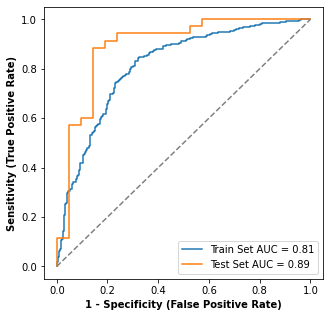

In [51]:
#AUC curve
# Assuming fpr_val, tpr_val, and auc_val contain the FPR, TPR, and AUC for the validation set
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_proba_train, pos_label='tumor')
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_proba_test, pos_label='tumor')
auc_value_train = roc_auc_score(y_train, y_pred_proba_train)
auc_value_test = roc_auc_score(y_test, y_pred_proba_test)

plt.figure(figsize=(5, 5))

# plot ROC curve for the train set
plt.plot(fpr_train, tpr_train, label=f'Train Set AUC = {auc_value_train:.2f}')

# Plot ROC curve for the test set
plt.plot(fpr_test, tpr_test, label=f'Test Set AUC = {auc_value_test:.2f}')

# Plot ROC curve for the validation set
# plt.plot(fpr_val, tpr_val, label=f'Validation Set AUC = {auc_value_val:.2f}', linestyle='-.')  # You can change the linestyle as you like

# Plot diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Labels, title, and other settings
plt.xlabel('1 - Specificity (False Positive Rate)', fontweight='bold')
plt.ylabel('Sensitivity (True Positive Rate)', fontweight='bold')
legend = plt.legend(loc='lower right')
plt.grid(False)
plt.show()

auprc_train: 0.8607623883166957
auprc_test: 0.9050383291939963


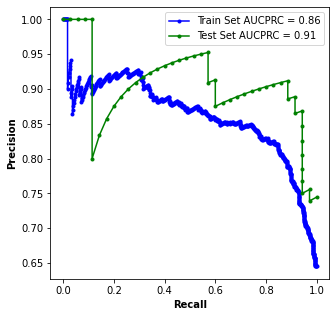

In [52]:
#precision-recall
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train,pos_label='tumor')
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test,pos_label='tumor')
auprc_train = auc(recall_train, precision_train)
print("auprc_train:", auprc_train)
auprc_test = auc(recall_test, precision_test)
print("auprc_test:", auprc_test)

# precision_val, recall_val, _ = precision_recall_curve(y_val, y_pred_proba_val,pos_label='tumor')


plt.figure(figsize=(5, 5))
plt.plot(recall_train, precision_train, marker='.', label=f'Train Set AUCPRC = {auprc_train:.2f}', color='blue')

# Plot for test set
plt.plot(recall_test, precision_test, marker='.', label=f'Test Set AUCPRC = {auprc_test:.2f}', color='green')

# Plot for validation set
# plt.plot(recall_val, precision_val, marker='.', label='Validation', color='red')

# Labeling the axes and setting the title
plt.xlabel('Recall',fontweight='bold')
plt.ylabel('Precision',fontweight='bold')
#plt.title('Exosome Cohort benign vs cancer',fontweight='bold')

# Display the legend
plt.legend()
# Show the plot
plt.show()

In [53]:
#p is the optimal value
y_pred_train_labels = ["tumor" if p >= 0.56 else "normal" for p in y_pred_proba_train]
y_pred_test_labels = ["tumor" if p >= 0.69  else "normal" for p in y_pred_proba_test]

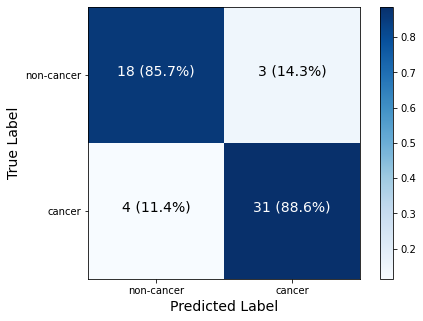

In [54]:
classes = ['non-cancer', 'cancer']
plot_confusion_matrix(y_test, y_pred_test_labels, classes)
plt.show()